In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
with open('review_game.p', 'rb') as f:
    review_game = pickle.load(f)
with open('meta_game.p', 'rb') as f:
    meta_game = pickle.load(f)
with open('product_sentiment_new.p', 'rb') as f:
    product_sentiment = pickle.load(f)
review_game.shape,meta_game.shape,product_sentiment.shape

((98842, 12), (7869, 18), (4305, 108))

In [4]:
# review>=5
review_size = review_game.groupby('asin').size()
has_many_review_ids = review_size[review_size>=5].index

product_sentiment_clean = product_sentiment[product_sentiment['asin'].isin(has_many_review_ids)].copy()
product_sentiment_clean.index = range(len(product_sentiment_clean))
product_sentiment_clean.drop('sentimentJson2',axis=1,inplace=True)
has_many_review_ids.shape,product_sentiment_clean.shape

((2854,), (2833, 107))

In [5]:
# ratings
review_game_clean = review_game[review_game['asin'].isin(has_many_review_ids)]
ratings = review_game_clean.groupby('asin').mean()['overall']
ratings.shape

(2854,)

In [6]:
# price
meta_game_clean = meta_game[['asin']].copy()
meta_game_clean['true_price'] = meta_game['price'].apply(lambda x:''.join(x[1:].split(','))).astype('float')
meta_game_clean = meta_game_clean[meta_game_clean['asin'].isin(has_many_review_ids)]
meta_game_clean = meta_game_clean.groupby('asin').mean()['true_price'].reset_index()
# decide whether to normalize
meta_game_clean['true_price'] = (meta_game_clean['true_price'] - np.mean(meta_game_clean['true_price']))/np.std(meta_game_clean['true_price'])

(4.45945945945946, 2.450338600451467, (2833, 109))

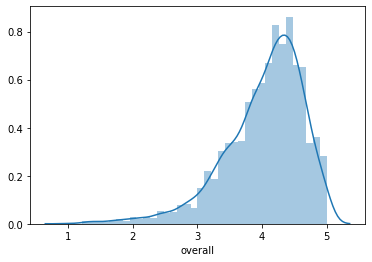

In [13]:
###### merge all into one dataset
data_ = product_sentiment_clean.merge(meta_game_clean,on='asin')
data = data_.merge(pd.DataFrame(ratings).reset_index(),on='asin')

# fig,ax = plt.subplots(1,1,figsize=(12,6))
# font = {'size': 10}
# matplotlib.rc('font', **font)
sns.distplot(data['overall'])
np.percentile(data['overall'],75),sum(data['overall']<4.5)/sum(data['overall']>=4.4),data.shape

In [6]:
# cut reviews into 2 bins
data_ml = data.copy().set_index('asin')
data_ml['rating'] = np.where(data_ml['overall']>=4.4,1,0)
data_ml.drop('overall',axis=1,inplace=True)
data_ml.head()

,new,different,old,older,original,real,realistic,classic,easy,mini,...,nintendo,gba,god of war,zelda,mech,sonic,golden sun,pokemon,true_price,rating
asin,,,,,,,,,,,,,,,,,,,,,
0700026657,0.365330,-0.405892,-0.372278,NaN,NaN,-0.380437,NaN,NaN,0.706482,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.654826,0
1616616873,0.710812,NaN,-0.539911,NaN,NaN,-0.853276,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.383553,1
B000003SQQ,0.414180,NaN,0.000000,0.771995,0.490134,NaN,NaN,NaN,0.812955,NaN,...,-0.465283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.747643,0
B000006OTB,NaN,-0.447915,0.000000,NaN,NaN,0.000000,NaN,NaN,0.323535,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.511140,0
B000006OWS,0.989148,-0.389798,NaN,NaN,0.569282,NaN,NaN,0.779153,-0.374368,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.654448,0


In [7]:
# add review size as variable
ids= data_ml.index
review_size = review_size[ids]
review_size = (review_size - np.mean(review_size))/np.std(review_size)
data_ml = data_ml.join(pd.DataFrame(review_size[ids],columns=['n_reviews']))
data = data.join(pd.DataFrame(review_size[ids],columns=['n_reviews']))

In [8]:
data_ml.columns

Index(['new', 'different', 'old', 'older', 'original', 'real', 'realistic',
       'classic', 'easy', 'mini',
       ...
       'gba', 'god of war', 'zelda', 'mech', 'sonic', 'golden sun', 'pokemon',
       'true_price', 'rating', 'n_reviews'],
      dtype='object', length=109)

# Machine Learning

## Feature engineering

In [11]:
data_ml.head()

,new,different,old,older,original,real,realistic,classic,easy,mini,...,gba,god of war,zelda,mech,sonic,golden sun,pokemon,true_price,rating,n_reviews
asin,,,,,,,,,,,,,,,,,,,,,
0700026657,0.365330,-0.405892,-0.372278,NaN,NaN,-0.380437,NaN,NaN,0.706482,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.654826,0,0.340521
1616616873,0.710812,NaN,-0.539911,NaN,NaN,-0.853276,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.383553,1,-0.239887
B000003SQQ,0.414180,NaN,0.000000,0.771995,0.490134,NaN,NaN,NaN,0.812955,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.747643,0,-0.180661
B000006OTB,NaN,-0.447915,0.000000,NaN,NaN,0.000000,NaN,NaN,0.323535,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.511140,0,-0.275422
B000006OWS,0.989148,-0.389798,NaN,NaN,0.569282,NaN,NaN,0.779153,-0.374368,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.654448,0,-0.168816


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression,f_classif,SelectKBest

import statsmodels.discrete.discrete_model as sm
import warnings
warnings.filterwarnings("ignore")
import pickle

In [13]:
seed=123
np.random.seed(seed)

In [14]:
def model_cross_validation(model,X,y,folds):
    kfolds=len(folds)
    train_accuracy=np.empty(kfolds)
    validation_accuracy=np.empty(kfolds)
    auc=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train2=X[train]
        y_train2=y[train]
        model.fit(X_train2,y_train2)
        X_validation=X[validation]
        y_validation=y[validation]
        y_score = model.predict_proba(X_validation)[:,1]
        train_accuracy[idx]=np.mean(model.predict(X_train2)==y_train2)
        validation_accuracy[idx]=np.mean(model.predict(X_validation)==y_validation)
        auc[idx] = roc_auc_score(y_validation, y_score)
    return train_accuracy,validation_accuracy,auc

In [15]:
# transform into binary
def binary_substitude(row,sub):
    if isinstance(sub,str):
        if pd.isna(row[sub]):
            return 0
        else:
            return 1
    elif isinstance(sub,tuple):
        judge = 0
        for i in sub:
            if not pd.isna(row[i]):
                judge = 1
        return judge

# use mean value
def keyword_substitude(row,sub):
    return np.nanmean(row[list(sub)])

In [16]:
#remove some factors
data_ml.drop(['player'],axis=1,inplace=True)

In [17]:
substitude = [('old','older'),('real','realistic'),('character','characters'),('control','controls'),('enemy','enemies'),
              ('weapon','weapons'),('review','reviews'),('detail','details'),('attack','attacks'),('animation','animations'),
              ('movie','movies'),('twist','twisted'),('moves','movement','movements'),('magic','magical'),('combo','combos'),
              ('story','storyline','plot')]
for sub in substitude:
    if isinstance(sub,str):
        column_name = 'agg_'+sub
    elif isinstance(sub,tuple):
        column_name = 'agg_'+sub[0]
    data_ml[column_name] = data_ml.apply(lambda row: keyword_substitude(row,sub),axis=1)
    if isinstance(sub,str):
        data_ml.drop(sub,axis=1,inplace=True)
    elif isinstance(sub,tuple):
        for i in sub:
            data_ml.drop(i,axis=1,inplace=True)

In [18]:
substitude2 = ['wii','final fantasy','resident evil','sega gt','star wars','mario','madden','digimon','call of duty',
               ('nintendo','gba'),'god of war','zelda','mech','sonic','golden sun','pokemon','xbox']
for sub in substitude2:
    if isinstance(sub,str):
        column_name = 'series_'+sub
    elif isinstance(sub,tuple):
        column_name = 'series_'+sub[0]
    data_ml[column_name] = data_ml.apply(lambda row: binary_substitude(row,sub),axis=1)
    if isinstance(sub,str):
        data_ml.drop(sub,axis=1,inplace=True)
    elif isinstance(sub,tuple):
        for i in sub:
            data_ml.drop(i,axis=1,inplace=True)

In [19]:
substitude3 = [('action','battle','fight','combat','fighting','fighter','shoot','shooting'),'adventure','rpg','strategy',
               ('sport','sports','basketball','football','baseball','race',"racing","car","wrestling"),('puzzle','puzzles','card'),
               ('kid','kids',"kid's","kids'"),'multiplayer']
for sub in substitude3:
    if isinstance(sub,str):
        column_name = 'type_'+sub
    elif isinstance(sub,tuple):
        column_name = 'type_'+sub[0]
    data_ml[column_name] = data_ml.apply(lambda row: binary_substitude(row,sub),axis=1)
    if isinstance(sub,str):
        data_ml.drop(sub,axis=1,inplace=True)
    elif isinstance(sub,tuple):
        for i in sub:
            data_ml.drop(i,axis=1,inplace=True)

In [21]:
data_ml.fillna(0,inplace=True)
data_ml.head()

,new,different,original,classic,easy,mini,difficulty,level,mode,graphics,...,series_pokemon,series_xbox,type_action,type_adventure,type_rpg,type_strategy,type_sport,type_puzzle,type_kid,type_multiplayer
asin,,,,,,,,,,,,,,,,,,,,,
0700026657,0.365330,-0.405892,0.000000,0.000000,0.706482,0.0,0.0,-0.337928,-0.74645,0.460396,...,0,0,1,0,0,0,0,0,0,1
1616616873,0.710812,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,...,0,0,1,0,0,0,0,0,0,0
B000003SQQ,0.414180,0.000000,0.490134,0.000000,0.812955,0.0,0.0,0.829781,0.00000,0.555355,...,0,0,1,0,0,1,0,0,1,0
B000006OTB,0.000000,-0.447915,0.000000,0.000000,0.323535,0.0,0.0,-0.943968,0.00000,0.581704,...,0,0,1,0,0,0,0,0,1,0
B000006OWS,0.989148,-0.389798,0.569282,0.779153,-0.374368,0.0,0.0,0.000000,0.00000,0.609479,...,0,0,0,1,0,1,0,1,1,0


In [23]:
### Train-test set split
train,test = train_test_split(data_ml,test_size=0.25,shuffle=True)
train.shape,test.shape  # Too many features compared to the sample size

((2124, 69), (709, 69))

In [24]:
train.shape,test.shape

((2124, 69), (709, 69))

## Resample

In [25]:
x_train = train.drop('rating',axis=1,inplace=False).values
y_train = train['rating'].values
x_test = test.drop('rating',axis=1,inplace=False).values
y_test = test['rating'].values
names = train.drop('rating',axis=1,inplace=False).columns
x_train.shape,x_test.shape

((2124, 68), (709, 68))

In [26]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(0.5,random_state=2)
# x_train, y_train = smote.fit_sample(x_train, y_train)

In [27]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(0.5)
x_train, y_train = rus.fit_sample(x_train, y_train)

In [28]:
x_train.shape,sum(y_train==0),sum(y_train==1)

((1983, 68), 1322, 661)

In [29]:
### K-folds
kf=KFold(5,shuffle=True)     
folds=list(kf.split(x_train))

## Feature Selection Based on Importance

In [30]:
x_train_df = pd.DataFrame(x_train,columns=names)

def simple_feature_importance(X, y, model='reg'):
    score_func = {'reg': f_regression,
                  'clas': f_classif}
    # Score each of the features
    bestfeatures = SelectKBest(score_func=score_func[model], k='all')
    fit = bestfeatures.fit(X, y)
    # Organize and return the scores
    featureScores = pd.DataFrame([X.columns, fit.scores_]).T
    featureScores.columns = ['Feature', 'Score']
    return featureScores.sort_values('Score', ascending=False).set_index('Feature')

### Try to get a threshold based on p-values
feature_names = list(x_train_df.columns)

def f_test(x, y, feature_names, p_cutoff = 0.05):

    from sklearn.feature_selection import f_regression
    num_features = len(feature_names)
    raw_scores, p_values = f_regression(x, y)
    scores = np.zeros(num_features)

    #just keep non statistically significant scores at 0
    for i in range(num_features):
        if (p_values[i] < p_cutoff):
            scores[i] = raw_scores[i]
    return dict(zip(feature_names,scores))

In [31]:
score_data = f_test(x_train_df, y_train, feature_names, p_cutoff = 0.1)
score_data = {key:val for key, val in score_data.items() if val != 0}

In [32]:
importance_scores = simple_feature_importance(x_train_df, y_train, model='clas')
importance_scores = importance_scores[importance_scores['Score']>=min(score_data.values())]
keyword_importance = list(importance_scores.index)

In [33]:
# Get the remaining variables (need to excl. rating to get all IVs.)
keyword_importance[:5]

['level', 'new', 'gameplay', 'graphics', 'difficulty']

In [34]:
names2 = keyword_importance
x_train2 = x_train_df[names2].values
x_test2 = test[names2].values
x_train2.shape,x_test2.shape

((1983, 49), (709, 49))

## Feature Selection - rfe

In [35]:
x_train3 = pd.DataFrame(x_train,columns=names)
x_test3 = pd.DataFrame(x_train,columns=names)
names3 = names

# make a threshold for quasi constant.
threshold = 0.98

# create empty list
quasi_constant_feature = []

# loop over all the columns
for feature in x_train3.columns:

    # calculate the ratio.
    predominant = (x_train3[feature].value_counts() / np.float(len(x_train3))).sort_values(ascending=False).values[0]
    
    # append the column name if it is bigger than the threshold
    if predominant >= threshold:
        quasi_constant_feature.append(feature)   
        
print(quasi_constant_feature)

# drop the quasi constant columns
x_train3.drop(labels=quasi_constant_feature, axis=1,inplace=True)
x_test3.drop(labels=quasi_constant_feature, axis=1,inplace=True)
names3.drop(labels=quasi_constant_feature)

['series_sega gt', 'series_digimon', 'series_god of war', 'series_mech', 'series_golden sun']


Index(['new', 'different', 'original', 'classic', 'easy', 'mini', 'difficulty',
       'level', 'mode', 'graphics', 'gameplay', 'series', 'look', 'mission',
       'quality', 'team', 'boss', 'sound', 'music', 'style', 'monster',
       'voice', 'camera', 'price', 'scenes', 'true_price', 'n_reviews',
       'agg_old', 'agg_real', 'agg_character', 'agg_control', 'agg_enemy',
       'agg_weapon', 'agg_review', 'agg_detail', 'agg_attack', 'agg_animation',
       'agg_movie', 'agg_twist', 'agg_moves', 'agg_magic', 'agg_combo',
       'agg_story', 'series_wii', 'series_final fantasy',
       'series_resident evil', 'series_star wars', 'series_mario',
       'series_madden', 'series_call of duty', 'series_nintendo',
       'series_zelda', 'series_sonic', 'series_pokemon', 'series_xbox',
       'type_action', 'type_adventure', 'type_rpg', 'type_strategy',
       'type_sport', 'type_puzzle', 'type_kid', 'type_multiplayer'],
      dtype='object')

In [36]:
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30)

# build the RFE with CV option.
rfe = RFECV(model, min_features_to_select = 3, step = 1 , cv=5, scoring='accuracy')

# fit the RFE to our data.
selection  = rfe.fit(x_train3, y_train)

# print the selected features.
print(x_train3.columns[selection.support_])

Index(['new', 'different', 'original', 'classic', 'easy', 'mini', 'difficulty',
       'level', 'mode', 'graphics', 'gameplay', 'series', 'look', 'mission',
       'quality', 'team', 'boss', 'sound', 'music', 'style', 'monster',
       'voice', 'camera', 'price', 'scenes', 'true_price', 'n_reviews',
       'agg_old', 'agg_real', 'agg_character', 'agg_control', 'agg_enemy',
       'agg_weapon', 'agg_review', 'agg_detail', 'agg_attack', 'agg_animation',
       'agg_movie', 'agg_twist', 'agg_moves', 'agg_magic', 'agg_combo',
       'agg_story', 'series_wii', 'series_nintendo', 'series_xbox',
       'type_action', 'type_adventure', 'type_sport', 'type_puzzle',
       'type_kid'],
      dtype='object')


In [37]:
names3 = x_train3.columns[selection.support_]
x_train3 = x_train3[names3].values
x_test3 = x_test3[names3].values
x_train3.shape,x_test3.shape

((1983, 51), (1983, 51))

## Random forest - feature selection

In [38]:
### Random Forest - grid serach
parameters = {
     'n_estimators':range(5,30,5),
     'max_depth': range(1,10,1),
     'min_samples_split': range(10,100,20),
}
model_RF = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
model_RF.fit(x_train,y_train)
best_C_RF = model_RF.best_params_
best_C_RF

{'max_depth': 9, 'min_samples_split': 30, 'n_estimators': 25}

In [39]:
### Random Forest - grid serach (feature importance)
model_RF2 = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
model_RF2.fit(x_train2,y_train)
best_C_RF2 = model_RF2.best_params_
best_C_RF2

{'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 20}

In [40]:
### Random Forest - grid serach (rfe)
model_RF3 = GridSearchCV(RandomForestClassifier(),parameters,cv=5)
model_RF3.fit(x_train3,y_train)
best_C_RF3 = model_RF3.best_params_
best_C_RF3

{'max_depth': 9, 'min_samples_split': 70, 'n_estimators': 15}

In [41]:
# conclude
best_RF = RandomForestClassifier(     
    n_estimators=best_C_RF['n_estimators'],
     max_depth= best_C_RF['max_depth'],
     min_samples_split= best_C_RF['min_samples_split'])
best_RF2 = RandomForestClassifier(     
    n_estimators=best_C_RF2['n_estimators'],
     max_depth= best_C_RF2['max_depth'],
     min_samples_split= best_C_RF2['min_samples_split'])
best_RF3 = RandomForestClassifier(     
    n_estimators=best_C_RF3['n_estimators'],
     max_depth= best_C_RF3['max_depth'],
     min_samples_split= best_C_RF3['min_samples_split'])
models = [best_RF,best_RF2,best_RF3]

columns=['RF','RF-feature importance','RF-rfe']
vacc = pd.DataFrame(columns=columns)
auc = pd.DataFrame(columns=columns)
train_accuracy,validation_accuracy,auc_ = model_cross_validation(models[0],x_train,y_train,folds)
vacc[columns[0]]= validation_accuracy
auc[columns[0]] = auc_
train_accuracy2,validation_accuracy2,auc_2 = model_cross_validation(models[1],x_train2,y_train,folds)
vacc[columns[1]]= validation_accuracy2
auc[columns[1]] = auc_2
train_accuracy3,validation_accuracy3,auc_3 = model_cross_validation(models[2],x_train3,y_train,folds)
vacc[columns[2]]= validation_accuracy3
auc[columns[2]] = auc_3

Text(0, 0.5, 'AUC')

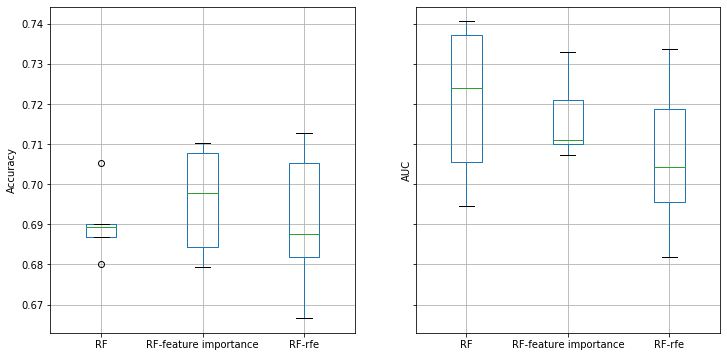

In [42]:
fig,axes = plt.subplots(1,2,figsize=(12,6),sharey=True)
vacc.boxplot(ax=axes[0])
auc.boxplot(ax=axes[1])
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('AUC')

# Interpretation

In [88]:
rf = best_RF.fit(x_train,y_train)

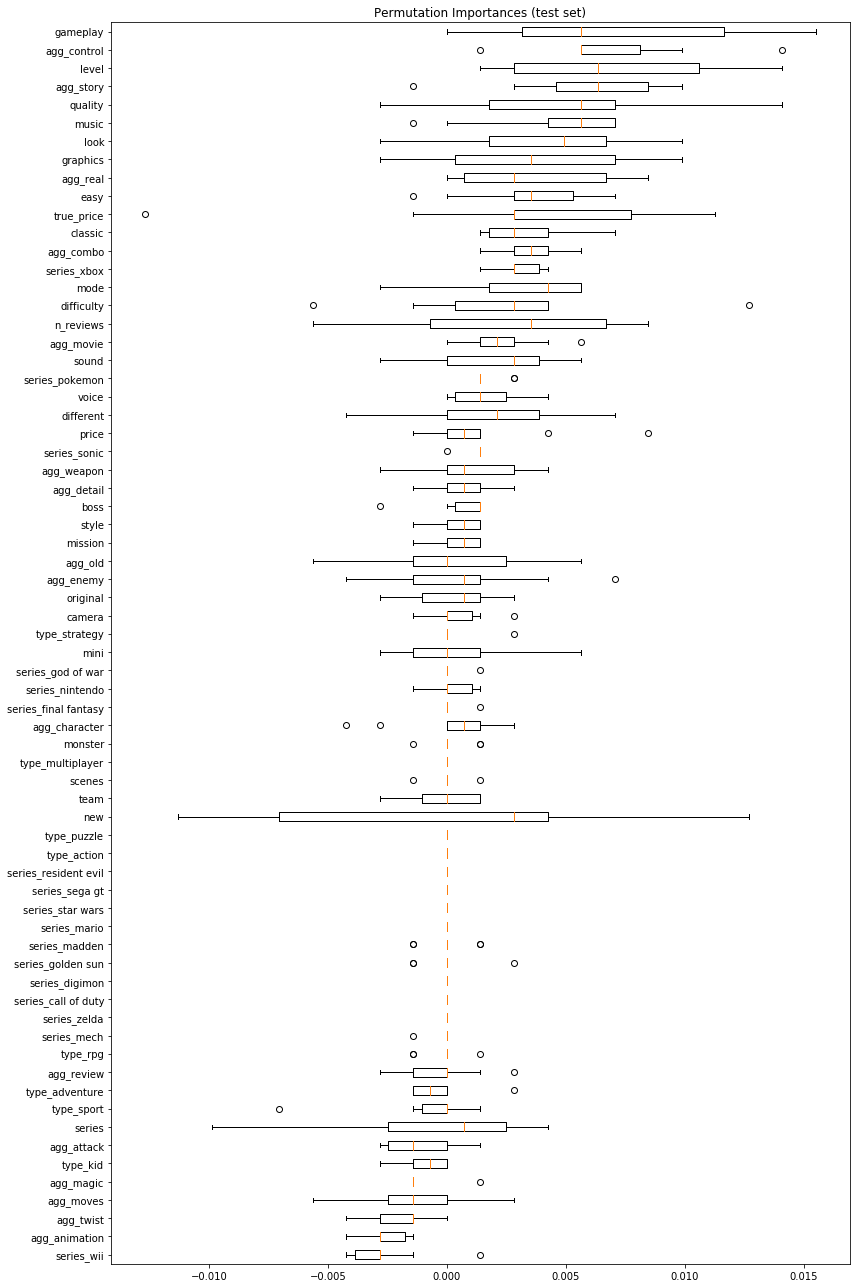

In [89]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig,ax= plt.subplots(1,1,figsize=(12,18))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()